## A brief model to show how to import the proposed model in the paper, how to get it trained and make predictions


In [1]:
import pickle
import time
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim

from enc_dec_with_atten import cooling_model ## The proposed model (Model I)
# from enc_dec_without_atten import cooling_model ## The model without attention (Model II)

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_input, data_output):

        super(CustomDataset, self).__init__()
        self.output_seq = data_output
        self.input_seq = data_input
        # self.transform = transform
        #self.target_transform = target_transform
        
    def __len__(self):
        return len(self.input_seq)
    
    
    def __getitem__(self, idx):
        input_seq = self.input_seq[idx, :, :]
        output_seq = self.output_seq[idx, :, :]

        return input_seq, output_seq

In [3]:
def train_(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
               
        device = model.device
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg).to(device)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        # output = output[1:].view(-1, output_dim)
        # trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [4]:
def evaluate_(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src, trg) in enumerate(iterator):

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            # output = output[1:].view(-1, output_dim)
            # trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), output

In [5]:
config = {
    "enc_hid_dim": 20,
    "dec_hid_dim": 20,
    "dropout": 0.1,
    "data_dir":r'.\temp_data\public_data.pt',
    "model_type": 'GRU',
    "batch_size": 128,
    "n_epochs": 5,
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "train_ratio": 0.9,
}

In [6]:
device = config['device']
data_dir = config['data_dir']
### load data

train_data_X, train_data_Y, test_data_X, test_data_Y = torch.load(config['data_dir'])['data']
INPUT_DIM = train_data_X.shape[2]
OUTPUT_DIM = train_data_Y.shape[2]
BATCH_SIZE = config['batch_size']
src_len = train_data_X.shape[1]
trg_len = train_data_Y.shape[1]

In [7]:
## [batches, steps, input_dim]
train_data_X.shape

torch.Size([8016, 24, 7])

In [8]:
train_data = CustomDataset(train_data_X, train_data_Y)
test_data = CustomDataset(test_data_X, test_data_Y)

num_train = int(len(train_data) * config['train_ratio'])
split_train_, split_valid_ = random_split(train_data, [num_train, len(train_data) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [9]:
## prepare model
model = cooling_model(INPUT_DIM, OUTPUT_DIM, device, enc_hid_dim=config['enc_hid_dim'], dec_hid_dim=config['dec_hid_dim'],
                  dropout=config['dropout'], model_type=config['model_type'])

In [10]:
epoch_loss = 0
optimizer = optim.Adam(model.parameters())
criterion=nn.MSELoss()
N_EPOCHS = config['n_epochs']
CLIP = 1  
best_valid_loss = float('inf')

In [11]:
loss = []
for epoch in range(N_EPOCHS):
    print(epoch)
    
    train_loss = train_(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, output = evaluate_(model, valid_dataloader, criterion)
    
    loss.append([train_loss, valid_loss])
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        optimal_model = model

0
1
2
3
4


<AxesSubplot:title={'center':'Error in training stage'}>

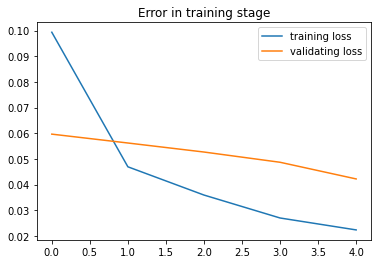

In [12]:
loss = pd.DataFrame(loss, columns=['training loss', 'validating loss'])
loss.plot(title='Error in training stage')

In [13]:
## make prediction
test_loss, output = evaluate_(model, test_dataloader, criterion)

In [14]:
test_loss

0.042880404740571976

In [15]:
output.shape

torch.Size([2904, 24, 7])